Initial cost: [21.88065055]

Final cost: [17.55438536]

Final weights and biases:
Ws:
 [[ 0.13679849  0.21250301 -0.16270926]]
bs: [[ 0.24167737 -0.09136912  0.17526973]]
Wu: [[ 0.84136333 -0.6       ]
 [ 0.74683551  0.9       ]
 [ 0.51386654 -0.6       ]]
bu: [[ 0.51399764 -0.34      ]]
Wy:
 [[0.92700965]
 [0.5       ]]
by: [[0.77999704]]

Final predictions (VD): [[2.40890774]
 [2.5137368 ]
 [2.58974416]]

VR: [[1.72787774e+30]
 [9.73956039e+31]
 [1.81191708e+33]]


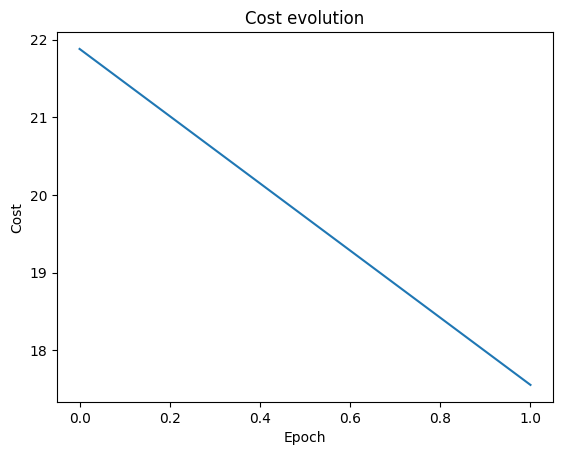

In [1]:
import pickle
from math import e

import matplotlib.pyplot as plt
import numpy as np

from scipy.special import expit

# Sigmoid function
def sigmoid(x):
    return expit(x)

def lambert(X):
    # Load weights and biases
    with open("lambert_model.pkl", "rb") as f:
        weights = pickle.load(f)
    Wu, bu, Wy, by = weights["Wu"], weights["bu"], weights["Wy"], weights["by"]

    layer1 = X @ Wu + np.ones((X.shape[0], 1)) @ bu
    layer2 = sigmoid(layer1)
    layer3 = layer2 @ Wy + np.ones((X.shape[0], 1)) @ by

    return layer3

def ReLU(x):
    return np.maximum(0, x)


def train_VD(X, Y, epochs):
    m = X.shape[0]
    mf = 0.5
    lr = 0.01

    Ws = np.array([[0.05, 0.15, -0.20]])

    bs = np.array([[0.23, -0.10, 0.17]])

    Wu = np.array([[0.8, -0.6], [0.7, 0.9], [0.5, -0.6]])

    bu = np.array([[0.45, -0.34]])

    Wy = np.array([[0.8], [0.5]])

    by = np.array([[0.7]])

    # Costs
    fs = np.zeros((epochs + 1, 1))

    # Momentum terms
    Ws_m = np.zeros_like(Ws)
    bs_m = np.zeros_like(bs)
    Wu_m = np.zeros_like(Wu)
    bu_m = np.zeros_like(bu)
    Wy_m = np.zeros_like(Wy)
    by_m = np.zeros_like(by)

    for i in range(epochs):
        # Forward pass
        V_5 = Ws
        V_4 = bs
        V_3 = Wu
        V_2 = bu
        V_1 = Wy
        V0 = by
        V1 = X @ V_5 + np.ones((m, 1)) @ V_4
        V2 = sigmoid(V1)
        V3 = V2 @ V_3 + np.ones((m, 1)) @ V_2
        V4 = ReLU(V3)
        V5 = V4 @ V_1 + np.ones((m, 1)) @ V0
        V6 = (1 / m) * ((Y - V5).T @ (Y - V5))
        fs[i] = V6

        # Backward pass
        # V6_ = 1
        V5_ = -2 / m * (Y - V5)
        V4_ = V5_ @ V_1.T
        V3_ = V4_ * (V3 > 0)  # ReLU derivative
        V2_ = V3_ @ V_3.T
        V1_ = (
            V2_ * V2 * (np.ones((V2.shape[0], V2.shape[1])) - V2)
        )  # Sigmoid derivative
        V0_ = np.ones((m, 1)).T @ V5_
        V_1_ = V4.T @ V5_
        V_2_ = np.ones((m, 1)).T @ V3_
        V_3_ = V2.T @ V3_
        V_4_ = np.ones((m, 1)).T @ V1_
        V_5_ = X.T @ V1_

        # Update weights and biases (first time without momentum)
        if i == 0:
            momentum = 0
        elif i == 1:
            momentum = mf

        Ws_m = momentum * Ws_m + (1 - momentum) * V_5_
        bs_m = momentum * bs_m + (1 - momentum) * V_4_
        Wu_m = momentum * Wu_m + (1 - momentum) * V_3_
        bu_m = momentum * bu_m + (1 - momentum) * V_2_
        Wy_m = momentum * Wy_m + (1 - momentum) * V_1_
        by_m = momentum * by_m + (1 - momentum) * V0_

        Ws -= lr * Ws_m
        bs -= lr * bs_m
        Wu -= lr * Wu_m
        bu -= lr * bu_m
        Wy -= lr * Wy_m
        by -= lr * by_m

    # Forward pass to get cost of last weights and biases
    V_5 = Ws
    V_4 = bs
    V_3 = Wu
    V_2 = bu
    V_1 = Wy
    V0 = by
    V1 = X @ V_5 + np.ones((m, 1)) @ V_4
    V2 = sigmoid(V1)
    V3 = V2 @ V_3 + np.ones((m, 1)) @ V_2
    V4 = ReLU(V3)
    V5 = V4 @ V_1 + np.ones((m, 1)) @ V0
    V6 = (1 / m) * ((Y - V5).T @ (Y - V5))
    fs[epochs] = V6

    return Ws, bs, Wu, bu, Wy, by, fs


def diode_tension(X):
    m = X.shape[0]

    # Load weights and biases
    with open("VD_model.pkl", "rb") as f:
        weights = pickle.load(f)
    Ws, bs, Wu, bu, Wy, by = (
        weights["Ws"],
        weights["bs"],
        weights["Wu"],
        weights["bu"],
        weights["Wy"],
        weights["by"],
    )

    layer1 = X @ Ws + np.ones((m, 1)) @ bs
    layer2 = sigmoid(layer1)
    layer3 = layer2 @ Wu + np.ones((m, 1)) @ bu
    layer4 = ReLU(layer3)
    layer5 = layer4 @ Wy + np.ones((m, 1)) @ by

    return layer5


def main():
    # Getting VD using the Lambert function from P2E2
    I0 = 1e-12
    ETA = 1
    VT = 0.026
    R = 100

    VCC = np.array([[3], [6], [9]])

    W0 = lambert(R * I0 / (ETA * VT) * e ** ((VCC + R * I0) / (ETA * VT))).real

    VD = VCC + R * I0 - ETA * VT * W0

    # Input data
    X = VCC
    Y = VD

    # Hyperparameters
    epochs = 1

    Ws, bs, Wu, bu, Wy, by, fs = train_VD(X, Y, epochs)

    print("Initial cost:", fs[0])
    print("\nFinal cost:", fs[-1])
    print("\nFinal weights and biases:")
    print("Ws:\n", Ws)
    print("bs:", bs)
    print("Wu:", Wu)
    print("bu:", bu)
    print("Wy:\n", Wy)
    print("by:", by)

    # Save weights and biases
    with open("VD_model.pkl", "wb") as f:
        pickle.dump({"Ws": Ws, "bs": bs, "Wu": Wu, "bu": bu, "Wy": Wy, "by": by}, f)

    # Get Vr using the trained model
    VD = diode_tension(X)
    I = I0 * (e ** (VD / (ETA * VT)) - 1)
    VR = R * I

    print("\nFinal predictions (VD):", VD)
    print("\nVR:", VR)

    # Plot cost
    plt.plot(range(epochs + 1), fs)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.title("Cost evolution")
    plt.show()

if __name__ == "__main__":
    main()
